<a href="https://colab.research.google.com/github/manav2101/zeotap/blob/main/MANAV_VERMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

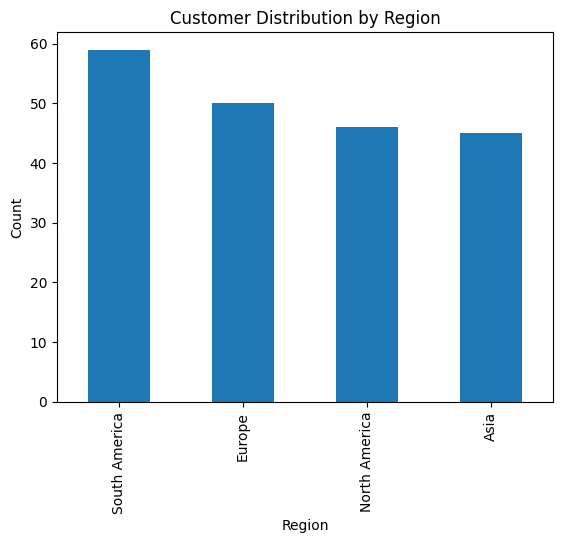

                         Quantity  TotalValue
ProductName                                  
ActiveWear Smartwatch         100    39096.97
SoundWave Headphones           97    25211.64
SoundWave Novel                58    24507.90
ActiveWear Jacket              76    22712.56
ActiveWear Rug                 79    22314.43
TechPro Headphones             45    19513.80
BookWorld Cookbook             48    19221.99
BookWorld Sweater              47    18743.79
TechPro Textbook               62    18267.96
ActiveWear Cookware Set        51    18083.73


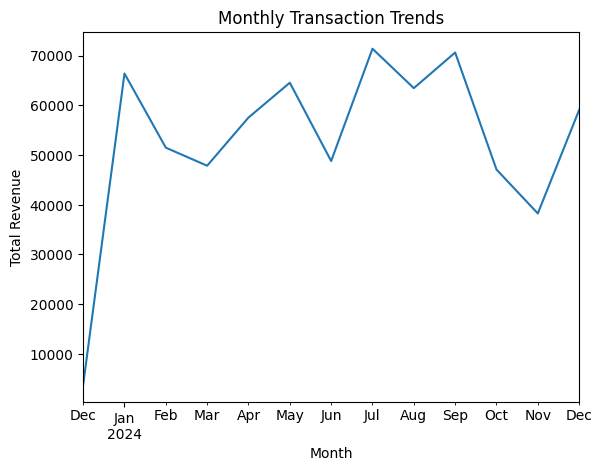

Region
Asia             697.591606
Europe           710.489872
North America    624.235246
South America    721.554474
Name: TotalValue, dtype: float64
DB Index: 0.8595340221510472
Silhouette Score: 0.37724079925411


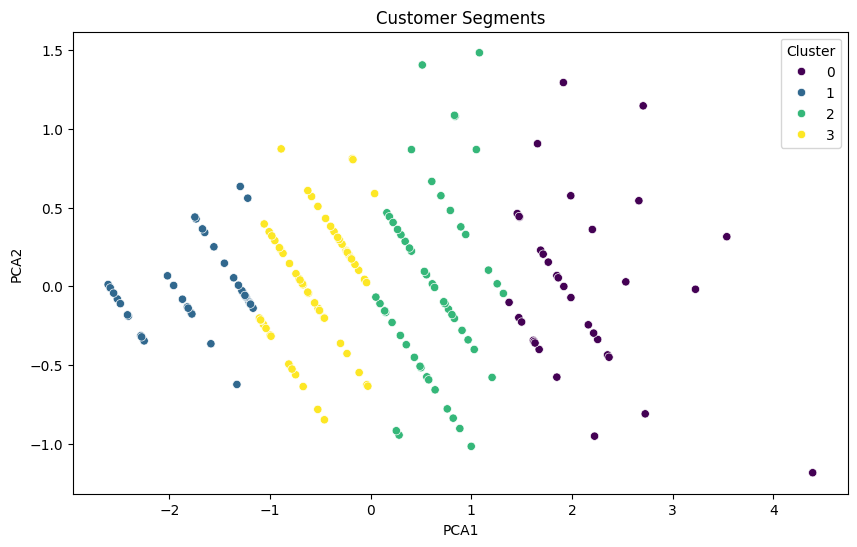

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# ------------------- TASK 1: EDA ------------------- #

customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

merged = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

region_distribution = customers['Region'].value_counts()
region_distribution.plot(kind='bar', title='Customer Distribution by Region', xlabel='Region', ylabel='Count')
plt.show()

top_products = merged.groupby('ProductName').agg({'Quantity': 'sum', 'TotalValue': 'sum'}).sort_values(by='TotalValue', ascending=False).head(10)
print(top_products)

merged['TransactionMonth'] = merged['TransactionDate'].dt.to_period('M')
monthly_trends = merged.groupby('TransactionMonth')['TotalValue'].sum()
monthly_trends.plot(title='Monthly Transaction Trends', xlabel='Month', ylabel='Total Revenue')
plt.show()

cltv = merged.groupby('CustomerID').agg({'TotalValue': 'sum', 'TransactionID': 'count'})
cltv.columns = ['TotalRevenue', 'TransactionCount']
cltv['AverageOrderValue'] = cltv['TotalRevenue'] / cltv['TransactionCount']

region_revenue = merged.groupby('Region')['TotalValue'].mean()
print(region_revenue)

# ------------------- TASK 2: LOOKALIKE MODEL ------------------- #

customer_features = merged.groupby('CustomerID').agg({
    'Region': lambda x: x.mode()[0],
    'Category': lambda x: x.mode()[0],
    'TotalValue': 'sum',
    'TransactionID': 'count'
})
customer_features['AvgTransactionValue'] = customer_features['TotalValue'] / customer_features['TransactionID']

scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(customer_features[['TotalValue', 'TransactionID', 'AvgTransactionValue']])

similarity_matrix = cosine_similarity(normalized_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features.index, columns=customer_features.index)

lookalike_results = {}
for customer_id in similarity_df.index[:20]:
    similar_customers = similarity_df.loc[customer_id].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer_id] = list(zip(similar_customers.index, similar_customers.values))

lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index', columns=['Lookalike1', 'Lookalike2', 'Lookalike3'])
lookalike_df.to_csv('Manav_Verma_Lookalike.csv', index_label='CustomerID')

# ------------------- TASK 3: CUSTOMER SEGMENTATION ------------------- #

segmentation_features = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count'
})
scaler = StandardScaler()
scaled_features = scaler.fit_transform(segmentation_features)

kmeans = KMeans(n_clusters=4, random_state=42)
segmentation_features['Cluster'] = kmeans.fit_predict(scaled_features)

db_index = davies_bouldin_score(scaled_features, segmentation_features['Cluster'])
silhouette_avg = silhouette_score(scaled_features, segmentation_features['Cluster'])
print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
segmentation_features['PCA1'] = reduced_features[:, 0]
segmentation_features['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=segmentation_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('Customer Segments')
plt.show()

segmentation_features.to_csv('Manav_Verma_Clustering.csv')
